In [1]:
import pandas as pd

# Load the RFM data (choose correct sheet)
df = pd.read_excel(r"C:\Users\Payal\Desktop\QNT_730_Business_Data_Mining\Term Project\rfm_analysis_outputs.xlsx", sheet_name="RFM Extended")



In [2]:
# R Quartile (lower recency = better score)
df['R_quartile'] = pd.qcut(df['Recency'], 4, labels=[4, 3, 2, 1])

# F Quartile (higher frequency = better score)
df['F_quartile'] = pd.qcut(df['Frequency'].rank(method='first'), 4, labels=[1, 2, 3, 4])

# M Quartile (higher monetary = better score)
df['M_quartile'] = pd.qcut(df['Monetary_Sum'], 4, labels=[1, 2, 3, 4])

In [3]:
# Convert quartiles to integers and calculate total RFM Score
df['RFM_Score'] = df[['R_quartile', 'F_quartile', 'M_quartile']].astype(int).sum(axis=1)
# Create RFM Segment by concatenating the quartile scores
df['RFM_Seg'] = (
    df['R_quartile'].astype(str) +
    df['F_quartile'].astype(str) +
    df['M_quartile'].astype(str)
)


In [4]:
print(df[['Customer ID', 'R_quartile', 'F_quartile', 'M_quartile', 'RFM_Seg', 'RFM_Score']])


      Customer ID R_quartile F_quartile M_quartile RFM_Seg  RFM_Score
0           12346          1          1          4     114          6
1           12747          4          4          4     444         12
2           12748          4          4          4     444         12
3           12749          4          3          4     434         11
4           12820          4          3          3     433         10
...           ...        ...        ...        ...     ...        ...
3915        18280          1          2          1     121          4
3916        18281          1          2          1     121          4
3917        18282          4          3          1     431          8
3918        18283          4          4          4     444         12
3919        18287          3          3          4     334         10

[3920 rows x 6 columns]


C:\Users\Payal\AppData\Local\Temp\ipykernel_27116\3251325434.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='RFM_Seg', palette='Spectral')


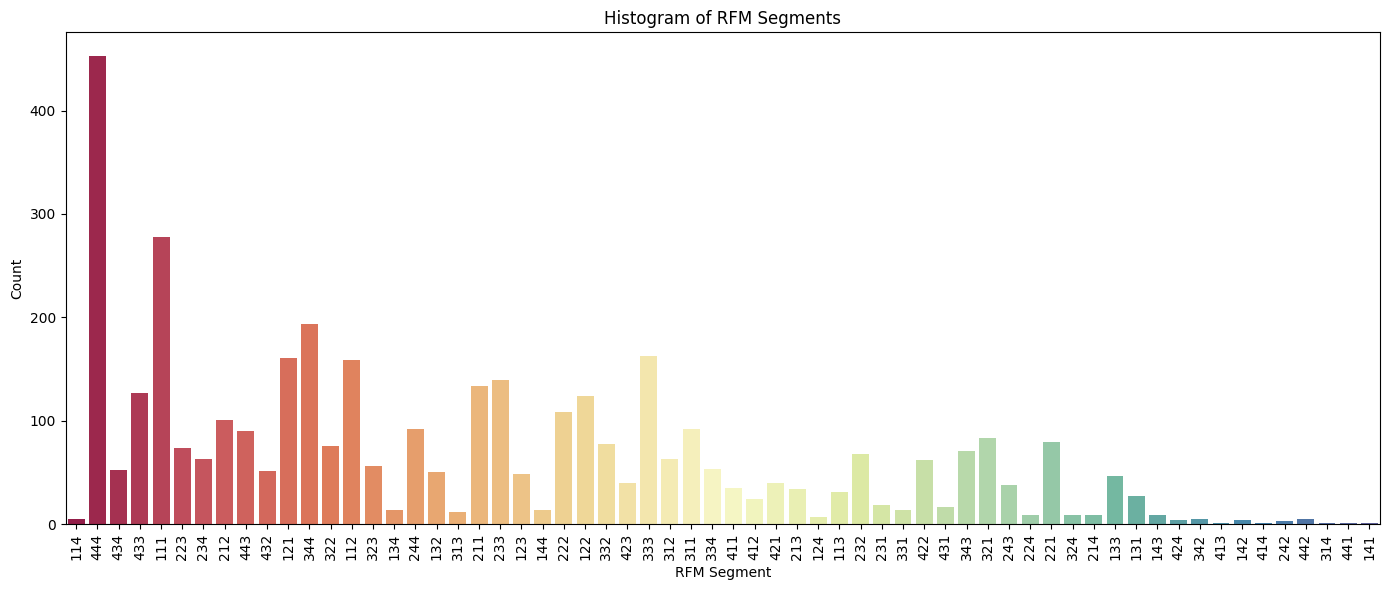

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the plot style
plt.figure(figsize=(14, 6))
sns.countplot(data=df, x='RFM_Seg', palette='Spectral')

# Customize plot
plt.title('Histogram of RFM Segments')
plt.xlabel('RFM Segment')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig(r'C:\Users\Payal\Desktop\QNT_730_Business_Data_Mining\Term Project\RFM_Segment_Histogram.png', dpi=300)
# Show plot
plt.show()


Recency  skewness:  1.24
Frequency skewness:  10.75
Monetary  skewness:  20.19


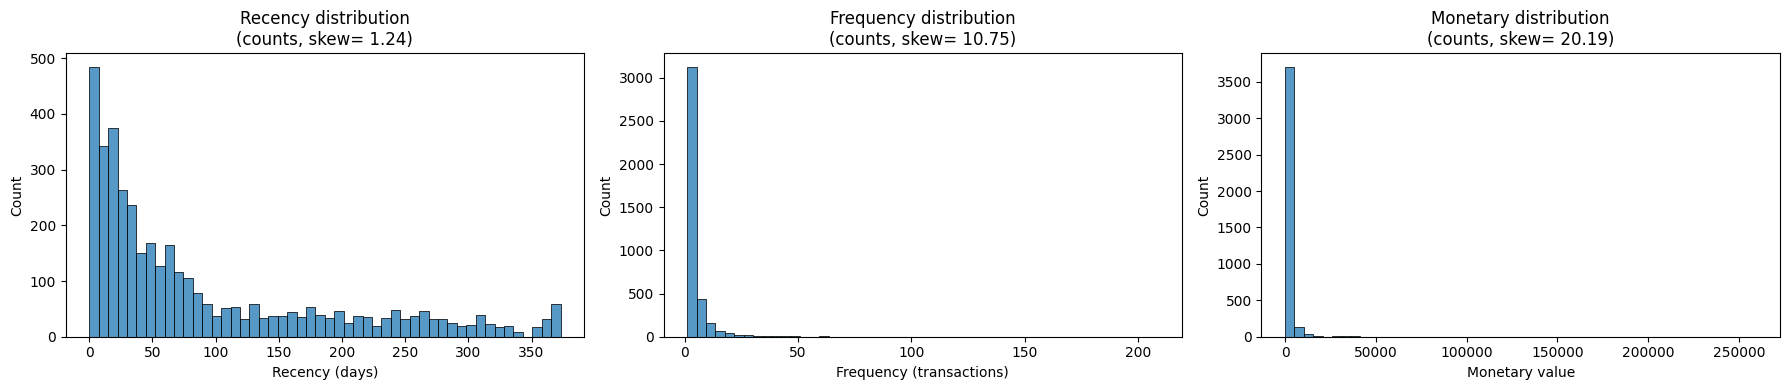

In [11]:
# -------------------------------------------------------------------
# 1.  Packages  (install only if you don't have them already)
# -------------------------------------------------------------------
# !pip install seaborn matplotlib scipy     # <-- uncomment if needed

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew

# -------------------------------------------------------------------
# 2.  Numeric skewness
# -------------------------------------------------------------------
r_skew = skew(df['Recency'])
f_skew = skew(df['Frequency'])
m_skew = skew(df['Monetary_Sum'])

print(f"Recency  skewness: {r_skew: .2f}")
print(f"Frequency skewness: {f_skew: .2f}")
print(f"Monetary  skewness: {m_skew: .2f}")

# -------------------------------------------------------------------
# 3.  Histograms – raw COUNTS
# -------------------------------------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

sns.histplot(df['Recency'],   bins=50, stat='count', ax=axes[0])
axes[0].set_title(f'Recency distribution\n(counts, skew={r_skew: .2f})')
axes[0].set_xlabel('Recency (days)')
axes[0].set_ylabel('Count')

sns.histplot(df['Frequency'], bins=50, stat='count', ax=axes[1])
axes[1].set_title(f'Frequency distribution\n(counts, skew={f_skew: .2f})')
axes[1].set_xlabel('Frequency (transactions)')
axes[1].set_ylabel('Count')

sns.histplot(df['Monetary_Sum'], bins=50, stat='count', ax=axes[2])
axes[2].set_title(f'Monetary distribution\n(counts, skew={m_skew: .2f})')
axes[2].set_xlabel('Monetary value')
axes[2].set_ylabel('Count')

plt.tight_layout()
plt.show()



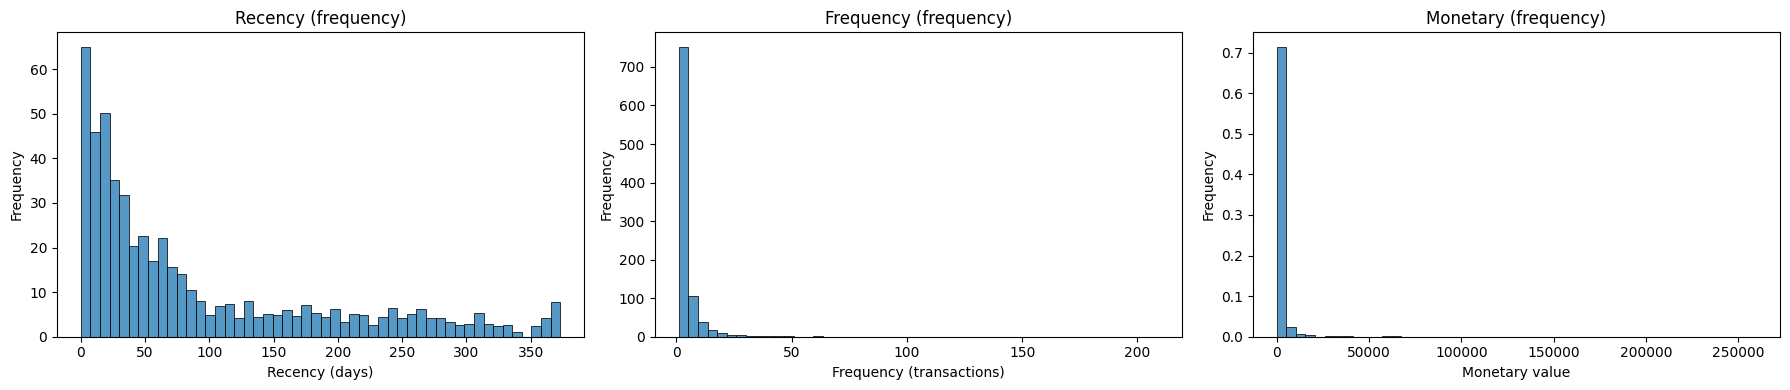

In [12]:
# -------------------------------------------------------------------
# 4.  Histograms – FREQUENCY (scaled by bin width; sum ≈ total count)
# -------------------------------------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

sns.histplot(df['Recency'],   bins=50, stat='frequency', ax=axes[0])
axes[0].set_title('Recency (frequency)')
axes[0].set_xlabel('Recency (days)')
axes[0].set_ylabel('Frequency')

sns.histplot(df['Frequency'], bins=50, stat='frequency', ax=axes[1])
axes[1].set_title('Frequency (frequency)')
axes[1].set_xlabel('Frequency (transactions)')
axes[1].set_ylabel('Frequency')

sns.histplot(df['Monetary_Sum'], bins=50, stat='frequency', ax=axes[2])
axes[2].set_title('Monetary (frequency)')
axes[2].set_xlabel('Monetary value')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


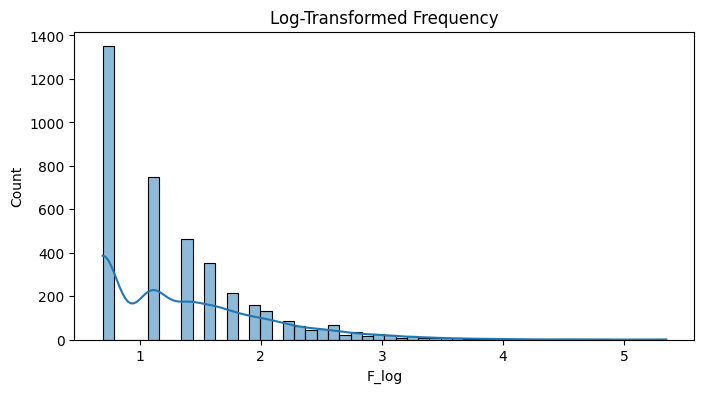

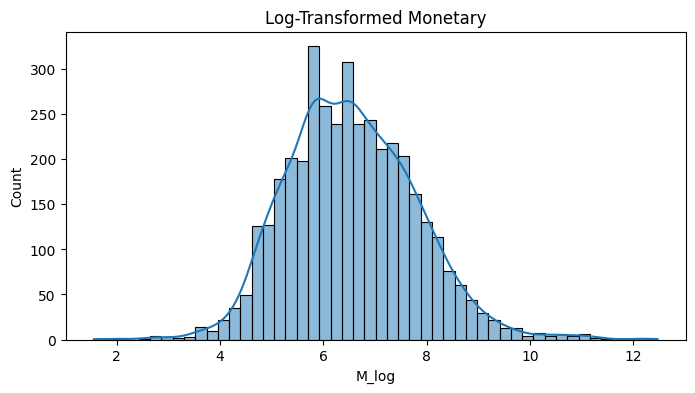

In [13]:
import numpy as np

# Apply log transformation to correct skewness
df['F_log'] = np.log1p(df['Frequency'])
df['M_log'] = np.log1p(df['Monetary_Sum'])

import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=(8, 4))
sns.histplot(df['F_log'], kde=True, bins=50)
plt.title("Log-Transformed Frequency")
plt.show()

plt.figure(figsize=(8, 4))
sns.histplot(df['M_log'], kde=True, bins=50)
plt.title("Log-Transformed Monetary")
plt.show()


Optimal number of clusters (k): 3


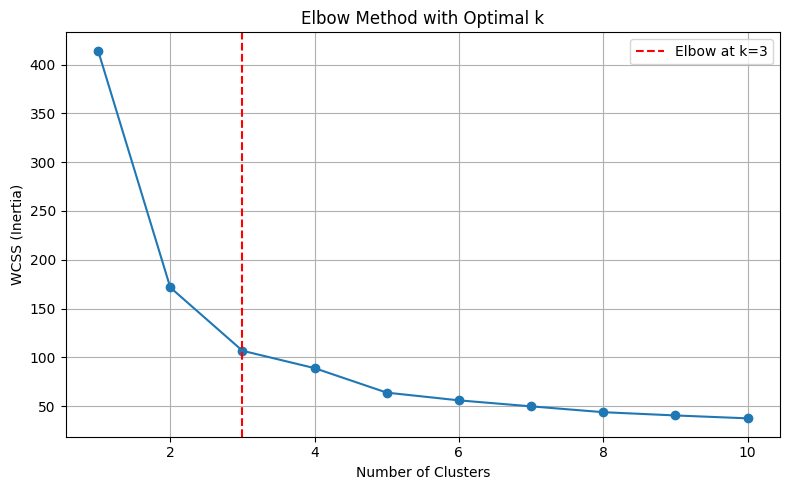

In [14]:
from kneed import KneeLocator
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler          # ⬅️ use range normalisation
import matplotlib.pyplot as plt

# 1. Log‑transformed RFM features
rfm_new = df[['Recency', 'F_log', 'M_log']]

# 2. Range‑normalise to [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
rfm_scaled = scaler.fit_transform(rfm_new)

# 3. Compute WCSS for k = 1 to 10
inertia = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

# 4. Locate the elbow
knee = KneeLocator(list(K), inertia, curve="convex", direction="decreasing")
optimal_k = knee.knee
print(f"Optimal number of clusters (k): {optimal_k}")

# 5. Plot and save
plt.figure(figsize=(8, 5))
plt.plot(K, inertia, marker='o')
plt.axvline(optimal_k, color='red', linestyle='--', label=f'Elbow at k={optimal_k}')
plt.title('Elbow Method with Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS (Inertia)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(r'C:\Users\Payal\Desktop\QNT_730_Business_Data_Mining\Term Project\Elbow.png', dpi=300)
plt.show()


In [15]:
# Step 1: KMeans was applied on rfm_scaled (log + scaled)
kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Step 2: Now describe the raw RFM values per cluster
cluster_summary = df.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary_Sum': 'mean'
}).round(2)

cluster_summary.columns = ['R_val', 'F_val', 'M_val']
print(cluster_summary)

          R_val  F_val    M_val
Cluster                        
0        252.31   1.56   604.10
1         55.79   2.04   625.46
2         22.35   9.94  4861.85


In [16]:
# Assuming df['Cluster'] already contains cluster labels

# Count instances and calculate percentage
cluster_counts = df['Cluster'].value_counts().sort_index()
cluster_percent = (cluster_counts / len(df) * 100).round(2)

# Create a summary table
summary_table = pd.DataFrame({
    'Cluster': cluster_counts.index + 1,  # if your cluster is 0-indexed and you want it to be 1-indexed
    'Frequency of cluster': cluster_counts.values,
    'Percentage': cluster_percent.values
})

print(summary_table)

   Cluster  Frequency of cluster  Percentage
0        1                   913       23.29
1        2                  1856       47.35
2        3                  1151       29.36


In [18]:
### Just to cross check if above is correct

# Step 1: Total from cluster summary
cluster_total = summary_table['Frequency of cluster'].sum()

# Step 2: Total number of records in your main DataFrame
data_total = len(df)

# Step 3: Cross-check
print(f"Sum of cluster frequencies: {cluster_total}")
print(f"Total number of records in dataset: {data_total}")

# Optional: check if they match
if cluster_total == data_total:
    print(" The cluster frequencies match the total number of records.")
else:
    print(" Mismatch! Check for unassigned or filtered rows.")


Sum of cluster frequencies: 3920
Total number of records in dataset: 3920
 The cluster frequencies match the total number of records.


Cluster 2 (≈ 47 % of all customers) is your most diverse group.
Why? It sits in the middle on every metric—neither churn‑risk like Cluster 1 nor VIP like Cluster 3—so it almost certainly contains several sub‑types of shoppers that one blunt cluster can’t capture.

Refine this cluster first. Break it into smaller, behaviour‑specific segments so you can tailor offers instead of sending the same message to half your database.



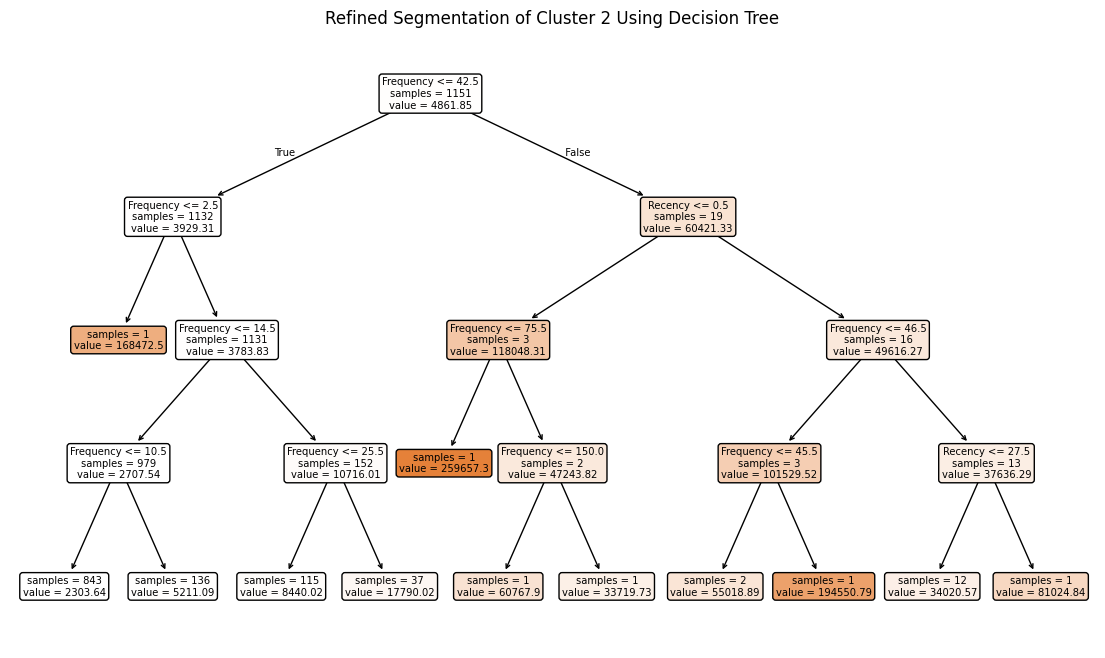

In [19]:
from sklearn.tree import DecisionTreeRegressor, plot_tree
import matplotlib.pyplot as plt
import pandas as pd

# Step 1: Filter for Cluster 2
cluster_data = df[df['Cluster'] == 2].copy()

# Step 2: Define features and target
X = cluster_data[['Recency', 'Frequency']]
y = cluster_data['Monetary_Sum']

# Step 3: Fit the regression tree
tree_reg = DecisionTreeRegressor(max_depth=4, random_state=42)
tree_reg.fit(X, y)

# Step 4: Plot the decision tree
plt.figure(figsize=(14, 8))
plot_tree(tree_reg, 
          feature_names=['Recency', 'Frequency'],
          filled=True,
          rounded=True,
          impurity=False,      # Hides MSE, shows average target (Monetary)
          precision=2)         # Show average values rounded to 2 decimals

plt.title("Refined Segmentation of Cluster 2 Using Decision Tree")
plt.savefig(r'C:\Users\Payal\Desktop\QNT_730_Business_Data_Mining\Term Project\DT.png', dpi=300)
plt.show()
